In [ ]:
!pip install torch torchvision --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 997.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 594.3/594.3 MB 59.0 MB/s eta 0:00:01^C


KeyboardInterrupt: 

In [ ]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp


In [ ]:
# Core
import os
import glob
import random
import string
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch + segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# TensorFlow + Keras (captioning transformer)
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import (
    Input, Dense, Embedding, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, add, RepeatVector
)
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Pickle
from pickle import dump, load
from google.colab import drive
from sklearn.model_selection import train_test_split

import torchvision.transforms as T_CLASS
import torchvision.transforms.functional as T_FUNC



In [ ]:
#Mount Google Drive & Setup Kaggle

drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Image_Captioning/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Key from Google Drive is complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Key from Google Drive is complete!


# Segementation Model

In [ ]:
#Download PASCAL VOC 2012 Dataset
!kaggle datasets download -d sovitrath/voc-2012-segmentation-data -p ./data --unzip
print("Dataset downloaded!")

Dataset URL: https://www.kaggle.com/datasets/sovitrath/voc-2012-segmentation-data
License(s): CC0-1.0
 88% 278M/316M [00:00<00:00, 757MB/s] 
100% 316M/316M [00:00<00:00, 636MB/s]
Dataset downloaded!


Dataset Class and Data Preparation

In [ ]:
IMAGE_DIR = "./data/voc_2012_segmentation_data/train_images/"
LABEL_DIR = "./data/voc_2012_segmentation_data/train_labels/"

print(f"Checking image directory: {IMAGE_DIR}")
print(f"Checking label directory: {LABEL_DIR}")

if not os.path.exists(IMAGE_DIR):
    print(f"Error: Image directory not found at {IMAGE_DIR}")
if not os.path.exists(LABEL_DIR):
    print(f"Error: Label directory not found at {LABEL_DIR}")


# Get image and label paths
all_image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.jpg')))
all_label_paths = sorted(glob.glob(os.path.join(LABEL_DIR, '*.png')))

if len(all_image_paths) == 0 or len(all_label_paths) == 0:
    raise ValueError(
        "ERROR: No files found! Check IMAGE_DIR and LABEL_DIR paths in Cell 4. "
        f"Files found: {len(all_image_paths)}"
    )

print(f"Found {len(all_image_paths)} image files.")
print(f"Found {len(all_label_paths)} label files.")

from sklearn.model_selection import train_test_split

# Split data
train_images, val_images, train_labels, val_labels = train_test_split(
    all_image_paths, all_label_paths, test_size=0.2, random_state=42
)

print(f"Data split: {len(train_images)} training images, {len(val_images)} validation images.")


# Define the dataset class
class SegmentationDatasetAugmented(Dataset):
    def __init__(self, image_paths, label_paths, augment=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment
        self.size = (256, 256)

        # Define a normalization transform for images
        self.normalize = T_CLASS.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

        # Define the Resize transform
        self.resize_transform = T_CLASS.Resize(self.size)

        # Define ColorJitter here (Class-based)
        self.color_jitter = T_CLASS.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        import torchvision.transforms.functional as T_FUNC

        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.label_paths[idx]).convert("L")

        # Resize the image and mask
        image = self.resize_transform(image)

        mask = T_CLASS.Resize(self.size, interpolation=Image.NEAREST)(mask)

        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = T_FUNC.hflip(image)
                mask = T_FUNC.hflip(mask)

            # Random rotation
            if random.random() > 0.5:
                angle = random.randint(-20, 20)
                image = T_FUNC.rotate(image, angle)
                mask = T_FUNC.rotate(mask, angle, interpolation=Image.NEAREST)

            # Color jitter
            if random.random() > 0.5:
                 image = self.color_jitter(image)

        # Convert to tensor
        image = T_CLASS.ToTensor()(image)
        mask = T_CLASS.ToTensor()(mask)

        # Normalize the image
        image = self.normalize(image)

        # Mask ko binary (0 or 1)
        mask = (mask > 0).float()


        return image, mask

# Create Dataset instances
train_dataset = SegmentationDatasetAugmented(train_images, train_labels, augment=True)
val_dataset = SegmentationDatasetAugmented(val_images, val_labels, augment=False)

print("Dataset classes created with correct functional transform calls.")

Checking image directory: ./data/voc_2012_segmentation_data/train_images/
Checking label directory: ./data/voc_2012_segmentation_data/train_labels/
Found 1464 image files.
Found 1464 label files.
Data split: 1171 training images, 293 validation images.
Dataset classes created with correct functional transform calls.


U-Net Model Architecture

In [ ]:
NUM_CLASSES = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {DEVICE.upper()}")


model = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=3,classes=NUM_CLASSES).to(DEVICE)

print("Model  to ResNet34-based U-Net")

Running on device: CUDA
Model  to ResNet34-based U-Net


Weighted DiceBCE Loss Function

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight=1.5, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, inputs, targets, smooth=1e-6):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        # Dice loss
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        # Combined Weighted loss
        return (self.bce_weight * BCE) + (self.dice_weight * dice_loss)

loss_fn = DiceBCELoss()
print("Weighted DiceBCE Loss function ready (More focus on Dice Score)")

Weighted DiceBCE Loss function ready (More focus on Dice Score)


Training Configuration

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Running on device: {DEVICE.upper()}")

LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 50  # Increased from 35

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Optimizer, Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print(f"Setup complete!")
print(f"   - Train batches: {len(train_loader)}")
print(f"   - Val batches: {len(val_loader)}")

✅ Running on device: CUDA
Setup complete!
   - Train batches: 74
   - Val batches: 19


 Training Loop with Validation & Best Model Saving

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*50}")

    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc="Training", leave=False)

    for imgs, masks in loop:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        # Forward
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Learning Rate Scheduler Step
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, '/content/drive/MyDrive/ZidioProject/best_unet_model.pth')
        print(f" Best model saved! (Val Loss: {val_loss:.4f})")

print("\n Training Complete!")


Epoch 1/50


Train Loss: 0.9536 | Val Loss: 0.7818
 Best model saved! (Val Loss: 0.7818)

Epoch 2/50


Train Loss: 0.6791 | Val Loss: 0.6570
 Best model saved! (Val Loss: 0.6570)

Epoch 3/50


Train Loss: 0.5701 | Val Loss: 0.5672
 Best model saved! (Val Loss: 0.5672)

Epoch 4/50


Train Loss: 0.4904 | Val Loss: 0.5698

Epoch 5/50


Train Loss: 0.4586 | Val Loss: 0.5298
 Best model saved! (Val Loss: 0.5298)

Epoch 6/50


Train Loss: 0.3856 | Val Loss: 0.4992
 Best model saved! (Val Loss: 0.4992)

Epoch 7/50


Train Loss: 0.3621 | Val Loss: 0.4736
 Best model saved! (Val Loss: 0.4736)

Epoch 8/50


Train Loss: 0.3302 | Val Loss: 0.4747

Epoch 9/50


Train Loss: 0.3219 | Val Loss: 0.4657
 Best model saved! (Val Loss: 0.4657)

Epoch 10/50


Train Loss: 0.2822 | Val Loss: 0.4559
 Best model saved! (Val Loss: 0.4559)

Epoch 11/50


Train Loss: 0.2736 | Val Loss: 0.4731

Epoch 12/50


Train Loss: 0.2670 | Val Loss: 0.4443
 Best model saved! (Val Loss: 0.4443)

Epoch 13/50


Train Loss: 0.2666 | Val Loss: 0.4490

Epoch 14/50


Train Loss: 0.2622 | Val Loss: 0.4494

Epoch 15/50


Train Loss: 0.2457 | Val Loss: 0.4374
 Best model saved! (Val Loss: 0.4374)

Epoch 16/50


Train Loss: 0.2145 | Val Loss: 0.4447

Epoch 17/50


Train Loss: 0.2122 | Val Loss: 0.4134
 Best model saved! (Val Loss: 0.4134)

Epoch 18/50


Train Loss: 0.1933 | Val Loss: 0.4326

Epoch 19/50


Train Loss: 0.2108 | Val Loss: 0.4411

Epoch 20/50


Train Loss: 0.1890 | Val Loss: 0.4268

Epoch 21/50


Train Loss: 0.1838 | Val Loss: 0.4307

Epoch 22/50


Train Loss: 0.1682 | Val Loss: 0.4152

Epoch 23/50


Train Loss: 0.1540 | Val Loss: 0.4137

Epoch 24/50


Train Loss: 0.1457 | Val Loss: 0.4088
 Best model saved! (Val Loss: 0.4088)

Epoch 25/50


Train Loss: 0.1383 | Val Loss: 0.4074
 Best model saved! (Val Loss: 0.4074)

Epoch 26/50


Train Loss: 0.1421 | Val Loss: 0.4144

Epoch 27/50


Train Loss: 0.1436 | Val Loss: 0.4262

Epoch 28/50


Train Loss: 0.1408 | Val Loss: 0.4258

Epoch 29/50


Train Loss: 0.1350 | Val Loss: 0.4228

Epoch 30/50


Train Loss: 0.1288 | Val Loss: 0.4187

Epoch 31/50


Train Loss: 0.1252 | Val Loss: 0.4193

Epoch 32/50


Train Loss: 0.1244 | Val Loss: 0.4167

Epoch 33/50


Train Loss: 0.1208 | Val Loss: 0.4230

Epoch 34/50


Train Loss: 0.1174 | Val Loss: 0.4219

Epoch 35/50


Train Loss: 0.1226 | Val Loss: 0.4235

Epoch 36/50


Train Loss: 0.1177 | Val Loss: 0.4266

Epoch 37/50


Train Loss: 0.1200 | Val Loss: 0.4173

Epoch 38/50


Train Loss: 0.1145 | Val Loss: 0.4212

Epoch 39/50


Train Loss: 0.1128 | Val Loss: 0.4174

Epoch 40/50


Train Loss: 0.1118 | Val Loss: 0.4166

Epoch 41/50


Train Loss: 0.1155 | Val Loss: 0.4180

Epoch 42/50


Train Loss: 0.1098 | Val Loss: 0.4171

Epoch 43/50


Train Loss: 0.1114 | Val Loss: 0.4154

Epoch 44/50


Train Loss: 0.1155 | Val Loss: 0.4157

Epoch 45/50


Train Loss: 0.1120 | Val Loss: 0.4182

Epoch 46/50


Train Loss: 0.1106 | Val Loss: 0.4190

Epoch 47/50


Train Loss: 0.1111 | Val Loss: 0.4144

Epoch 48/50


Train Loss: 0.1186 | Val Loss: 0.4234

Epoch 49/50


Train Loss: 0.1107 | Val Loss: 0.4164

Epoch 50/50


Train Loss: 0.1119 | Val Loss: 0.4183

 Training Complete!


Visualize Training Progress

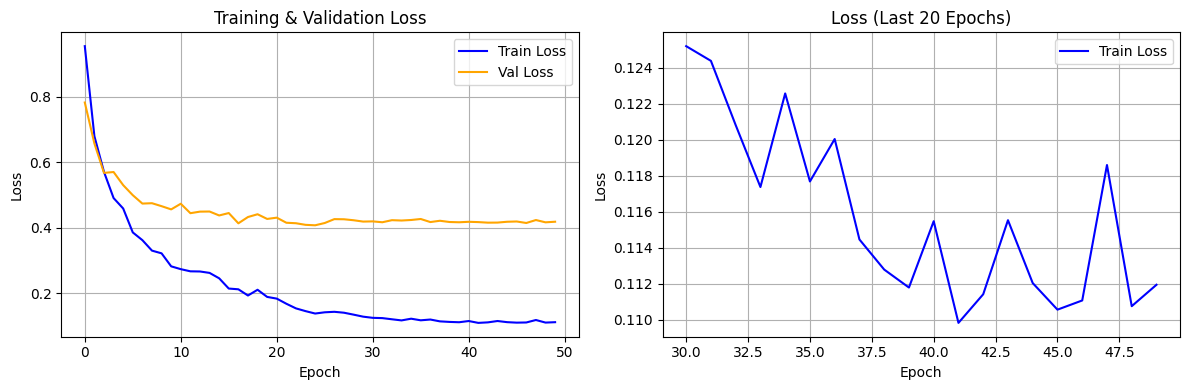

In [ ]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(max(0, NUM_EPOCHS-20), NUM_EPOCHS), train_losses[max(0, NUM_EPOCHS-20):], label='Train Loss', color='blue')
# plt.plot(range(max(0, NUM_EPOCHS-20), NUM_EPOCHS), val_losses[max(0, NUM_EPOCHS-20):], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Last 20 Epochs)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evalution

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating"):
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-6)

    accuracy = num_correct / num_pixels * 100
    avg_dice_score = dice_score / len(loader)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Dice Score: {avg_dice_score:.4f}")

    return accuracy, avg_dice_score

# Evaluate on validation set
print("\nValidation Set Evaluation:")
val_acc, val_dice = check_accuracy(val_loader, model, DEVICE)


Validation Set Evaluation:


Evaluating: 100%|██████████| 19/19 [00:02<00:00,  8.75it/s]

Accuracy: 91.03%
Dice Score: 0.8534


Test on Test Set

In [ ]:
valid_image_path = './data/voc_2012_segmentation_data/valid_images/'
valid_labels_path = './data/voc_2012_segmentation_data/valid_labels/'

test_images_list = sorted(glob.glob(os.path.join(valid_image_path, '*.jpg')))
test_labels_list = sorted(glob.glob(os.path.join(valid_labels_path, '*.png')))

test_dataset = SegmentationDatasetAugmented(test_images_list, test_labels_list, augment=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Test dataset ready with {len(test_dataset)} images.")

print("\nTest Set Evaluation:")
test_acc, test_dice = check_accuracy(test_loader, model, DEVICE)

Test dataset ready with 1449 images.

Test Set Evaluation:


Evaluating: 100%|██████████| 91/91 [00:14<00:00,  6.40it/s]

Accuracy: 90.81%
Dice Score: 0.8472


Save & Visualize Predictions


In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()

    # Get one batch
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)

    # Create folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()

    # Save images
    torchvision.utils.save_image(x, f"{folder}/original_images.png")
    torchvision.utils.save_image(y, f"{folder}/true_masks.png")
    torchvision.utils.save_image(preds, f"{folder}/pred_masks.png")

    model.train()
    print(f" Predictions saved to '{folder}'")

# Save predictions
save_predictions_as_imgs(test_loader, model, device=DEVICE)

 Predictions saved to 'saved_images/'


Load Best Saved Model

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/ZidioProject/best_unet_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']}")
print(f"   - Train Loss: {checkpoint['train_loss']:.4f}")
print(f"   - Val Loss: {checkpoint['val_loss']:.4f}")

# Re-evaluate
print("\n Evaluation with Best Model:")
check_accuracy(test_loader, model, DEVICE)

Best model loaded from epoch 25
   - Train Loss: 0.1383
   - Val Loss: 0.4074

 Evaluation with Best Model:


Evaluating: 100%|██████████| 91/91 [00:11<00:00,  8.24it/s]


Accuracy: 90.62%
Dice Score: 0.8441


(tensor(90.6168, device='cuda:0'), tensor(0.8441, device='cuda:0'))

# Captioning Model

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


dataset_text_path = r"/content/Flickr8k_text/Flickr8k.token.txt"
dataset_images_path = r"/content/Flickr8k_Dataset/"
save_features_path = r"/content/features.pkl"
save_tokenizer_path = r"/content/tokenizer.pkl"
save_model_path = r"/content/best_transformer_model.keras"

# Model Hyperparameters
EMBEDDING_DIM = 512
NUM_HEADS = 8
FF_DIM = 512
BATCH_SIZE = 64
LEARNING_RATE = 0.0003

# Global variables for vocab/max_length
vocab_size = 0
max_length = 0

print("Captioning Pipeline Setup Ready!")

Captioning Pipeline Setup Ready!


Feature Extraction

In [ ]:

dataset_images_path = r"/content/drive/My Drive/image_captioning/Flickr8k_Dataset"
save_features_path = r"/content/drive/My Drive/image_captioning/features.pkl"


def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    print("Starting Feature Extraction (This might take a few minutes)...")
    for img_name in tqdm(os.listdir(directory)):
        filename = os.path.join(directory, img_name)
        if not filename.endswith(('.jpg', '.jpeg', '.png')): continue
        try:
            image = load_img(filename, target_size=(299, 299))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[img_name] = feature
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            pass
    return features

if not os.path.exists(save_features_path):
    print("Extracting features...")
    features = extract_features(dataset_images_path)
    dump(features, open(save_features_path, "wb"))
    print(f"Features extracted and saved. Total Images: {len(features)}")
else:
    print("Features already available. Loading...")
    with open(save_features_path, "rb") as f:
        features = load(f)

Features already available. Loading...


Caption Loading, Cleaning, and Tokenization

In [ ]:

def load_doc(filename):
    with open(filename, 'r') as f: return f.read()

def load_descriptions(doc):
    mapping = {}
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2: continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping: mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i].split()
            desc = [w.lower() for w in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1 and word.isalpha()]
            desc_list[i] = ' '.join(desc)

dataset_text_path = r'/content/drive/My Drive/image_captioning/Flickr8k_text/Flickr8k.token.txt'
save_tokenizer_path = r'/content/drive/My Drive/image_captioning/tokenizer.pkl'

# Load data and prepare sequences
doc = load_doc(dataset_text_path)
descriptions = load_descriptions(doc)
clean_descriptions(descriptions)

#Add start/end tokens
for key in descriptions.keys():
    descriptions[key] = ['startseq ' + d + ' endseq' for d in descriptions[key]]

#Filter descriptions based on extracted features
image_ids = [k.split('.')[0] for k in features.keys()]
descriptions = {k: v for k, v in descriptions.items() if k in image_ids}


#Tokenizer Setup
all_captions = [caption for key in descriptions for caption in descriptions[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Set Global Variables
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

dump(tokenizer, open(save_tokenizer_path, 'wb'))

print(f"Captions Cleaned & Tokenizer Ready.")
print(f"   - Vocab Size: {vocab_size} | Max Length: {max_length}")

Captions Cleaned & Tokenizer Ready.
   - Vocab Size: 8766 | Max Length: 34


Data Generator Definition

In [ ]:
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = list(), list(), list()
        n = 0

        for key, desc_list in descriptions.items():
            if key + '.jpg' not in photos: continue

            photo = photos[key + '.jpg'][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1

                    if n == batch_size:
                        yield (tf.constant(np.array(X1), dtype=tf.float32), tf.constant(np.array(X2), dtype=tf.int32)), tf.constant(np.array(y), dtype=tf.float32)
                        X1, X2, y = list(), list(), list()
                        n = 0

        if n > 0:
            yield (tf.constant(np.array(X1), dtype=tf.float32), tf.constant(np.array(X2), dtype=tf.int32)), tf.constant(np.array(y), dtype=tf.float32)

print("Data Generator Function Defined.")

Data Generator Function Defined.


Transformer Model Architecture Definition

In [ ]:


EMBEDDING_DIM = 512
NUM_HEADS = 8
FF_DIM = 512
DROPOUT_RATE = 0.2
LEARNING_RATE_FINAL = 0.0003


def transformer_block(inputs, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout_rate=DROPOUT_RATE):

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)

    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


def define_model(max_length, vocab_size, embedding_dim=EMBEDDING_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM, learning_rate=LEARNING_RATE_FINAL):
    inputs1 = Input(shape=(2048,), name='Image_Input')
    fe1 = Dense(embedding_dim, activation='relu')(inputs1) # Map 2048 to 512
    fe2 = RepeatVector(max_length)(fe1) # Broadcast image context

    #Text Sequence Input
    inputs2 = Input(shape=(max_length,), name='Text_Input')
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)

    # Image Features + Text Embeddings
    se2 = add([fe2, se1]) # Sequence context fused with image context

    #Transformer Decoder (Layer 1)
    transformer_out = transformer_block(se2, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=DROPOUT_RATE)

    #Transformer Decoder (Layer 2 - CRITICAL ADDITION)
    transformer_out = transformer_block(transformer_out, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=DROPOUT_RATE)

    # Global Average Pooling
    transformer_out = GlobalAveragePooling1D()(transformer_out)

    #Output Layer
    outputs = Dense(vocab_size, activation='softmax')(transformer_out)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate))
    return model


print("Transformer Model Architecture UPGRADED (2-Layers, Increased Dimensions).")

Transformer Model Architecture UPGRADED (2-Layers, Increased Dimensions).


Training Execution

In [ ]:
BATCH_SIZE = 64

# EMBEDDING_DIM = 512
# NUM_HEADS = 8
# FF_DIM = 512
# LEARNING_RATE = 0.0003

# Define save_model_path
save_model_path = r"/content/drive/My Drive/ZidioProject/best_transformer_model.keras"

# Define the model
model = define_model(max_length, vocab_size, EMBEDDING_DIM, NUM_HEADS, FF_DIM, LEARNING_RATE)

# Calculate total number of input-output pairs
total_pairs = sum([len(tokenizer.texts_to_sequences([desc])[0]) - 1 for desc_list in descriptions.values() for desc in desc_list])
steps_per_epoch = total_pairs // BATCH_SIZE
if total_pairs % BATCH_SIZE != 0: steps_per_epoch += 1

print(f"Total training examples (pairs): {total_pairs}")
print(f"Steps per Epoch: {steps_per_epoch}")

generator = data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size=BATCH_SIZE)

checkpoint = ModelCheckpoint(
    save_model_path,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

earlystop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

print("\nStarting Training... (Expected to take several hours on GPU)")
model.fit(
    generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
    callbacks=[checkpoint, earlystop]
)

print("Training complete — Best model saved as:", save_model_path)

Total training examples (pairs): 413356
Steps per Epoch: 6459

Starting Training... (Expected to take several hours on GPU)
Epoch 1/30
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 5.8897
Epoch 1: loss improved from inf to 5.83255, saving model to /content/drive/My Drive/ZidioProject/best_transformer_model.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 922s 140ms/step - loss: 5.8897
Epoch 2/30
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 5.6655
Epoch 2: loss improved from 5.83255 to 5.70331, saving model to /content/drive/My Drive/ZidioProject/best_transformer_model.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 898s 139ms/step - loss: 5.6655
Epoch 3/30
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 5.5588
Epoch 3: loss improved from 5.70331 to 5.42673, saving model to /content/drive/My Drive/ZidioProject/best_transformer_model.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 893s 138ms/step - loss: 5.5588
Epoch 4/30
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 5.0262
Epoch 4: loss improv

IMAGE CAPTIONING TEST AND DISPLAY


Loading model and tokenizer...
=Model and tokenizer loaded!=
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


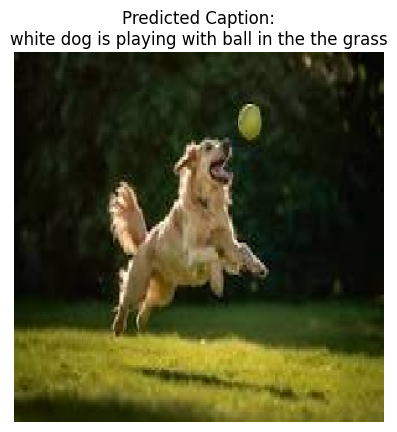


 Predicted Caption:
white dog is playing with ball in the the grass


In [ ]:
import pickle
from keras.models import load_model

model_path = r"/content/drive/My Drive/Image_Captioning/best_transformer_model.keras"
tokenizer_path = r"/content/drive/My Drive/Image_Captioning/tokenizer.pkl"
test_image_path = r"/content/drive/My Drive/Image_Captioning/download.jpg"

max_length = 34


print("Loading model and tokenizer...")
model = load_model(model_path, compile=False)
tokenizer = pickle.load(open(tokenizer_path, "rb"))
print("=Model and tokenizer loaded!=")

# Feature extractor
xception_model = Xception(include_top=False, pooling="avg")

def extract_features(filename):
    """Extract image features using Xception."""
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = xception_model.predict(image, verbose=0)
    return feature

# Caption generation functions
def idx_to_word(integer, tokenizer):
    """Convert integer index back to word."""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo, max_length):
    """Generate caption using greedy search."""
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    final_caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return final_caption


# Run test + display result
photo = extract_features(test_image_path)
caption = generate_caption(model, tokenizer, photo, max_length)

# Show image with caption
img = load_img(test_image_path, target_size=(299, 299))
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Caption:\n{caption}", fontsize=12, color='black')
plt.show()

print("\n Predicted Caption:")
print(caption)

Caption Accuracy Check

In [ ]:

model_path = "/content/drive/My Drive/Image_Captioning/best_transformer_model.keras"
tokenizer_path = "/content/drive/My Drive/Image_Captioning/tokenizer.pkl"
features_path = "/content/drive/My Drive/Image_Captioning/features.pkl"
text_path = "/content/drive/My Drive/Image_Captioning/Flickr8k_text/Flickr8k.token.txt"

model = load_model(model_path)
tokenizer = load(open(tokenizer_path, "rb"))
features = load(open(features_path, "rb"))
print("Model, Tokenizer & Features Loaded")

def load_doc(path): return open(path, 'r').read()
def clean_text(txt):
    t = str.maketrans('', '', string.punctuation)
    return ' '.join([w.lower().translate(t) for w in txt.split() if w.isalpha()])
desc = {}
for line in load_doc(text_path).split('\n'):
    if len(line) < 2: continue
    img, cap = line.split()[0], " ".join(line.split()[1:])
    desc.setdefault(img.split('.')[0], []).append("startseq " + clean_text(cap) + " endseq")

def predict_caption(model, feature, tok, max_len=34):
    text = 'startseq'
    for _ in range(max_len):
        seq = pad_sequences([tok.texts_to_sequences([text])[0]], maxlen=max_len)
        yhat = np.argmax(model.predict([feature, seq], verbose=0))
        word = tok.index_word.get(yhat)
        if word is None: break
        text += ' ' + word
        if word == 'endseq': break
    return text

#accurancy check
keys = list(set(desc.keys()) & set(k.split('.')[0] for k in features.keys()))
random.shuffle(keys)
keys = keys[:1]
total = correct = 0

for k in keys[:3]:
    f = features[k + '.jpg'].reshape(1, -1)
    pred = predict_caption(model, f, tokenizer).split()
    actual = desc[k][0].split()
    print(f"\n🖼 {k}\nActual : {' '.join(actual)}\nPred   : {' '.join(pred)}")
    for i in range(min(len(pred), len(actual))):
        total += 1
        if pred[i] == actual[i]: correct += 1

print(f"\nAccuracy: {correct/total*100:.2f}% (on 1 images)")


Model, Tokenizer & Features Loaded

🖼 3148811252_2fa9490a04
Actual : startseq a basketball player holds the ball during a game endseq
Pred   : startseq the basketball player in the red is challenging player player in endseq

Accuracy: 36.36% (on 1 images)


Display the Result

Using device: cpu
Segmentation model loaded successfully
Captioning model loaded successfully
Generated Caption: dog is jumping in the water at the beach


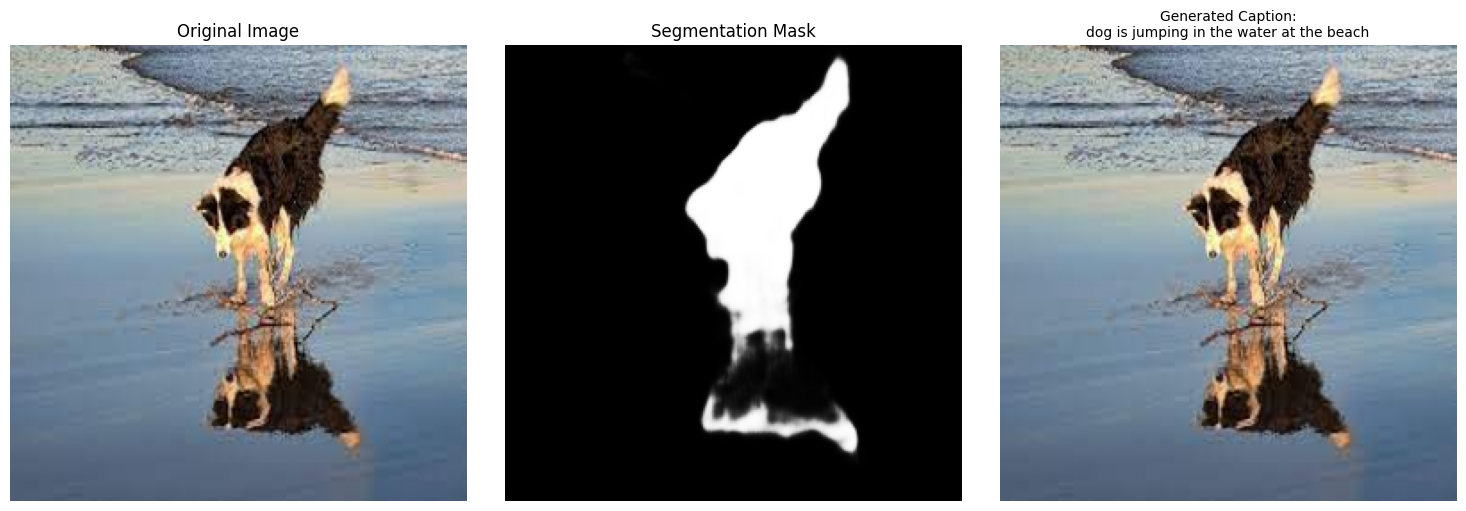


 Fusion pipeline executed.
Generated Caption: dog is jumping in the water at the beach


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


segmentation_model_path = "/content/drive/MyDrive/ZidioProject/best_unet_model.pth"


model_seg = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)


checkpoint = torch.load(segmentation_model_path, map_location=DEVICE)

model_seg.load_state_dict(checkpoint['model_state_dict'], strict=False)
model_seg.eval()

print("Segmentation model loaded successfully")

caption_model_path = "/content/drive/MyDrive/Image_Captioning/best_transformer_model.keras"
caption_model = load_model(caption_model_path, compile=False)
print("Captioning model loaded successfully")


def preprocess_image_seg(image_path, img_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(img_size)
    image_np = np.array(image) / 255.0
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    tensor = transform(image)
    return tensor.unsqueeze(0), image_np

def preprocess_image_caption(image_path, img_size=(299, 299)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(img_size)
    image_np = np.expand_dims(np.array(image), axis=0)
    return preprocess_input(image_np)


def generate_fused_caption(image_path):
    input_tensor_seg, original_image_np = preprocess_image_seg(image_path)

    with torch.no_grad():
        seg_output = model_seg(input_tensor_seg.to(DEVICE))
        seg_output = torch.sigmoid(seg_output).cpu().numpy()[0, 0]

    mask_resized_display = cv2.resize(seg_output, (original_image_np.shape[1], original_image_np.shape[0]))
    mask_resized_3channel = np.stack([mask_resized_display]*3, axis=-1)
    fused_image_np = original_image_np * (mask_resized_3channel > 0.5)

    xception_model = Xception(include_top=False, pooling="avg")
    image_features = xception_model.predict(preprocess_image_caption(image_path), verbose=0)

    from keras.preprocessing.sequence import pad_sequences

    tokenizer_path = "/content/drive/My Drive/Image_Captioning/tokenizer.pkl"
    with open(tokenizer_path, "rb") as f:
        caption_tokenizer = pickle.load(f)

    max_length = 34

    def idx_to_word(integer, tokenizer):
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    in_text = "startseq"
    image_features_reshaped = image_features.reshape(1, -1)

    for i in range(max_length):
        sequence = caption_tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features_reshaped, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, caption_tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    final_caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    print("Generated Caption:", final_caption)
    return final_caption, original_image_np, seg_output, fused_image_np


test_image_path = "/content/drive/My Drive/Image_Captioning/images.jpeg"
if not os.path.exists(test_image_path):
    print(f"Error: Test image not found at {test_image_path}")
else:
    caption, original_img, seg_mask, fused_img = generate_fused_caption(test_image_path)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(seg_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.title(f"Generated Caption:\n{caption}", fontsize=10, color='black')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("\n Fusion pipeline executed.")
    print("Generated Caption:", caption)